## Auto encoder for MNIST data

Load the data and setup the GPU

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
%cd /content/drive/MyDrive/Colab\ Notebooks/aml2024-students-copy/MiniAssignments/ma16_autoencoder

/content/drive/MyDrive/Colab Notebooks/aml2024-students-copy/MiniAssignments/ma16_autoencoder


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import numpy as np
from torch.autograd import Variable
import os

from torchvision import datasets
import torchvision.transforms as transforms

from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

device = torch.device("cuda")
plt.rcParams['figure.figsize'] = [12, 6]
if not os.path.exists("models"):
    os.makedirs(path)

mnist_data = datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor())


## Selecting only digits 0,..,MaxLabels to reduce computational complexity

In [8]:
MaxLabels = 3
mnist_data_reduced = mnist_data
idx = mnist_data.train_labels<MaxLabels
mnist_data_reduced.data = mnist_data.data[idx]
mnist_data_reduced.targets = mnist_data.targets[idx]


/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


## Set up the autoencoder class.

You may try with different number of features in the bottle neck layer. More parameters can improve the representation, but may result in poor generalization. The visualization is only posssible when the number of features in the bottleneck layer is 2.

The encoder uses the following structure

 <font color="red">784 $\rightarrow$ 128$\rightarrow$ 32 $\rightarrow$ 12 $\rightarrow$ 2</font>

The decoder uses the following structure

 <font color="red">2 $\rightarrow$ 12$\rightarrow$ 32 $\rightarrow$ 128 $\rightarrow$ 784</font>


In [9]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 32),
            nn.ReLU(True),
            nn.Linear(32, 12),
            nn.ReLU(True),
            nn.Linear(12, 2),
            nn.Tanh()
            )
        self.decoder = nn.Sequential(
            nn.Linear(2, 12),
            nn.ReLU(True),
            nn.Linear(12, 32),
            nn.ReLU(True),
            nn.Linear(32, 128),
            nn.ReLU(True),
            nn.Linear(128, 28 * 28),
            )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

## Defining the Training block

Notice that the innerloops are on batches. As the batch size decrease, the number of steepest descent steps increase. However, note that the gradients become increasingly approximate as the batch size becomes smaller. Thus, one is doing a lot of steps with inaccurate/noisy steps when batch size becomes smaller

On the converse, as the batch size becomes larger, the gradients are more accurate. However, the computational complexity increase with batch sizes. One is only able to do a few steps with accurate gradients.

In practice, the batch size is also a hyperparameter one needs to choose. Too high or too low batch sizes can hurt.

<font color=red>YOUR CODE BELOW </font>

In [12]:
def train(model, num_epochs=5, batch_size=2048, learning_rate=1e-3):
    torch.manual_seed(42)
    criterion = nn.MSELoss() # mean square error loss
    optimizer = torch.optim.Adam(
        model.parameters(), lr=learning_rate, weight_decay=1e-4)

    train_loader = torch.utils.data.DataLoader(mnist_data_reduced,
                                               batch_size=batch_size,
                                               shuffle=True)
    models = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        for data in train_loader:
            # get the image and move to gpu
            img, _ = data
            img = Variable(img).cuda(device).type(torch.cuda.FloatTensor)
            # convert as a vector
            img = img.view(img.size(0), -1)

            # YOUR CODE HERE
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward + backward + optimize
            outputs = model(img)
            loss = criterion(outputs, img)  # Assuming autoencoder style reconstruction
            loss.backward()
            optimizer.step()

            # Print statistics
            running_loss += loss.item()
        # print our average loss
        average_loss = running_loss / len(train_loader)
        # Saving the models at each epoch for visualization purposes
        fname = 'models/dict'+str(epoch)
        torch.save(model.state_dict(), fname)
        print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, float(loss)))

    return model


# Delete the old dictionaries

# Training block

In [13]:
model = autoencoder().cuda(device)

max_epochs = 10
model = train(model, num_epochs=max_epochs,batch_size=1000,learning_rate=1e-2)

Epoch:1, Loss:0.0570
Epoch:2, Loss:0.0519
Epoch:3, Loss:0.0488
Epoch:4, Loss:0.0456
Epoch:5, Loss:0.0468
Epoch:6, Loss:0.0477
Epoch:7, Loss:0.0454
Epoch:8, Loss:0.0438
Epoch:9, Loss:0.0449
Epoch:10, Loss:0.0429


# Displaying the progress with iterations

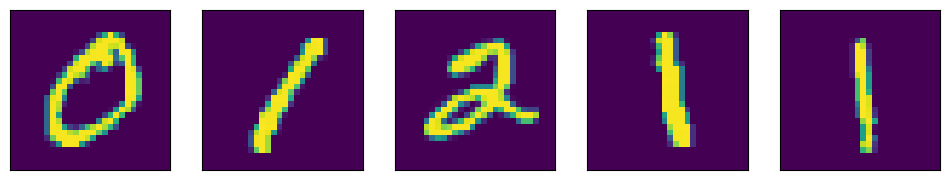

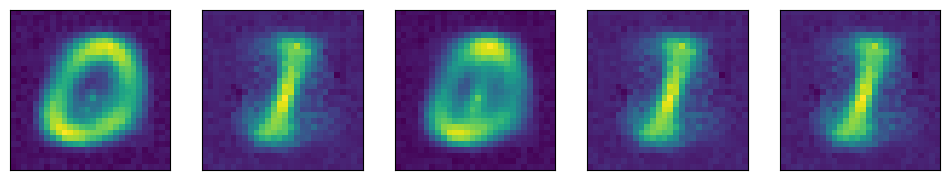

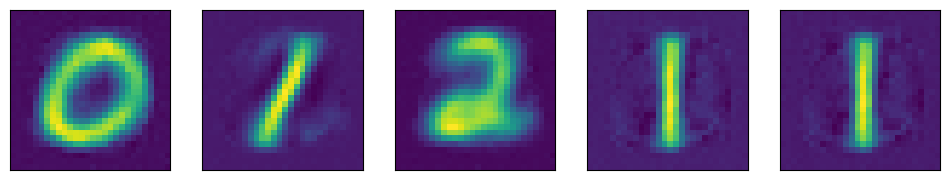

In [14]:
Ndisplay = 5
Nskip = 5
newmodel = autoencoder().cuda()

# Loading Ndisplay images
data_loader = torch.utils.data.DataLoader(mnist_data_reduced,
                                               batch_size=Ndisplay,
                                               shuffle=False)
img, _  = next(iter(data_loader))
img = img.view(img.size(0), -1)
img = Variable(img).cuda()
imgdisplay = img.detach().cpu().numpy()

# Displaying original images

fig,ax1 = plt.subplots(1,Ndisplay)
for i in range(Ndisplay):
    ax1[i].imshow(np.reshape(imgdisplay[i,:],(28,28)))
    ax1[i].get_xaxis().set_visible(False)
    ax1[i].get_yaxis().set_visible(False)

# Displaying results at each epochh
for epoch in range(0,max_epochs,Nskip):
  # loading model at each epoch
  fname = 'models/dict'+str(epoch)
  newmodel.load_state_dict(torch.load(fname))

  fig,ax2 = plt.subplots(1,Ndisplay)
  out = newmodel(img)
  out = out.detach().cpu().numpy()

  for i in range(Ndisplay):
    ax2[i].imshow(np.reshape(out[i,:],(28,28)))
    ax2[i].get_xaxis().set_visible(False)
    ax2[i].get_yaxis().set_visible(False)


#print(out.shape)

# Visualization of the embeddings that the encoder maps images

The points in the low-dimensional (bottle-neck layer) space are plotted as a scatter plot for diferent points

<font color=red>This code WILL ONLY DISPLAY THE FIRST TWO DIMENSIONS. WILL NOT BE ACCURATE when the latent variable is not two dimensional. </font>

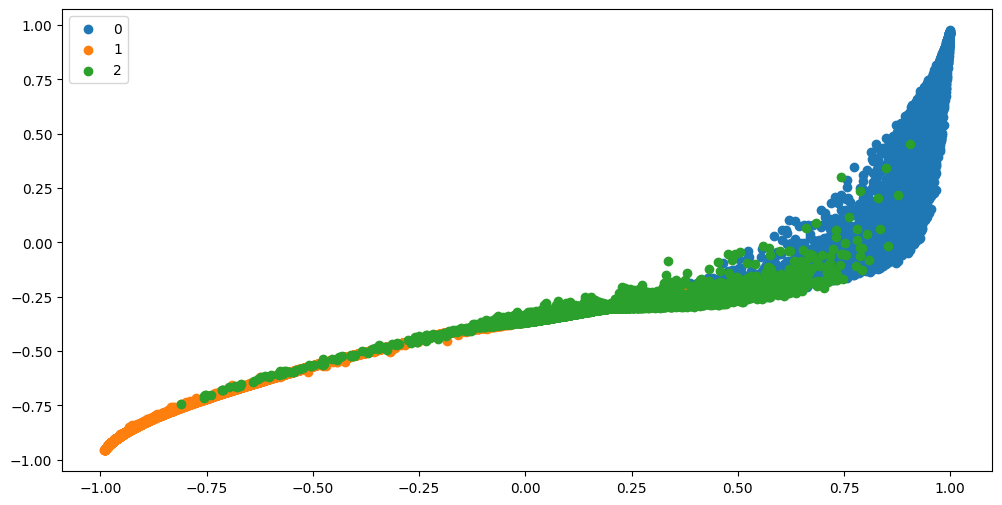

In [15]:
newmodel = autoencoder().cuda()
data_loader = torch.utils.data.DataLoader(mnist_data_reduced,
                                               batch_size=20000,
                                               shuffle=False)
fname = 'models/dict'+str(max_epochs-1)
newmodel.load_state_dict(torch.load(fname))
img, labels  = next(iter(data_loader))

img = img.view(img.size(0), -1)
img = Variable(img).cuda()
embedding = model.encoder(img).detach().cpu().numpy()
labels = labels.cpu().numpy()

plt.figure()
legtext = []
for i in range(MaxLabels):
  idx = (labels ==i)
  plt.scatter(embedding[idx,0],embedding[idx,1])
  legtext = np.hstack((legtext,str(i)))
  plt.legend(legtext)

# Visualizing the mapping of the latent space by the decoder

The latent space is sampled uniformly and the corresponding mapping of the images are displayed.

<font color=red>This code WILL ONLY WORK when the latent variable is not two dimensional. </font>

<Figure size 2000x2000 with 0 Axes>

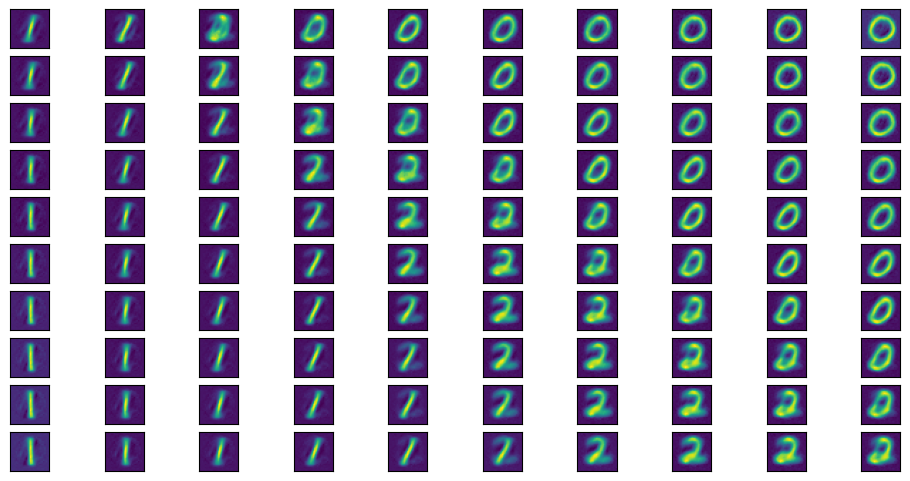

In [16]:
mtx_size = 10
[x,y] = np.meshgrid(np.linspace(-1,1,10),np.linspace(1,-1,10))
embedding = np.stack((x.ravel(),y.ravel()))
embedding = torch.tensor(embedding).T.cuda(device)
embedding = embedding.type(torch.cuda.FloatTensor)
embedding.shape
recons = model.decoder(embedding)
recons = recons.detach().cpu().numpy()

recons.shape
plt.figure(figsize=(20, 20))
fig,ax = plt.subplots(mtx_size,mtx_size)

i = 0
for x in range(mtx_size):
  for y in range(mtx_size):
    i = x*mtx_size + y
    ax[x][y].imshow(np.reshape(recons[i,],(28,28)))
    ax[x][y].get_xaxis().set_visible(False)
    ax[x][y].get_yaxis().set_visible(False)


# Interpolating in latent space

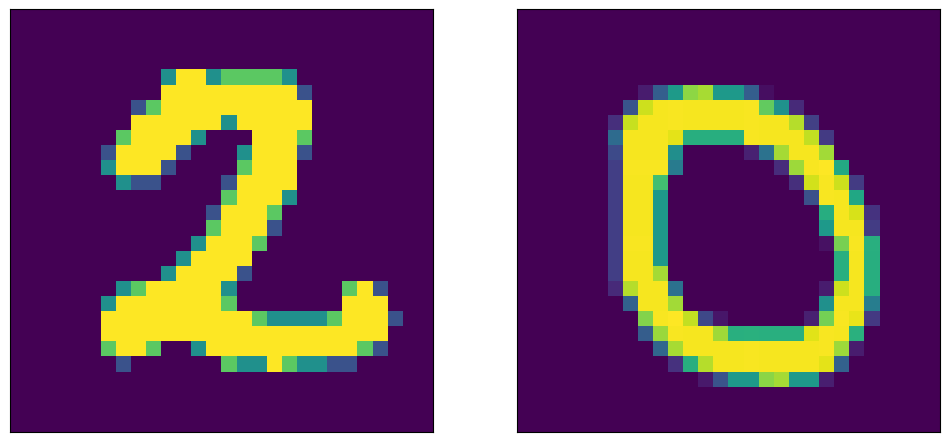

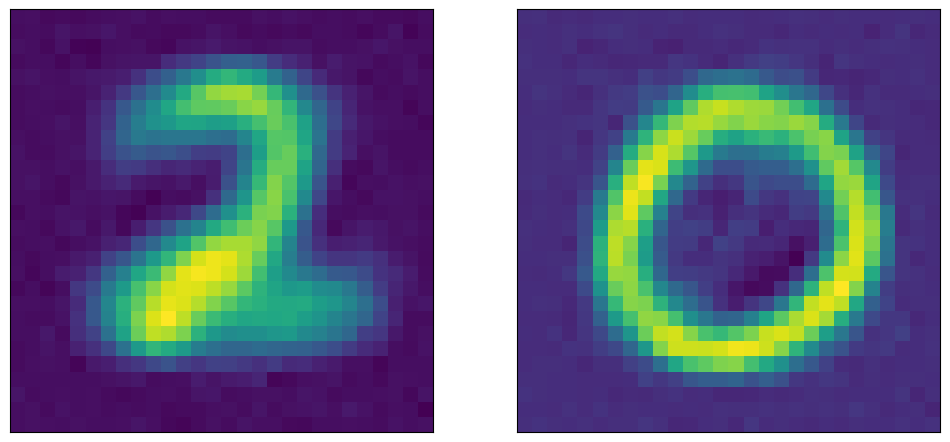

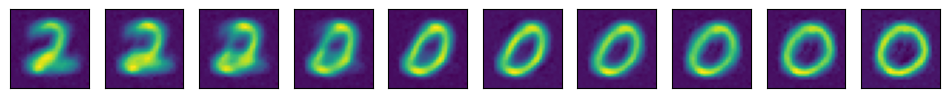

In [18]:
# Loading two random images
data_loader = torch.utils.data.DataLoader(mnist_data_reduced,
                                               batch_size=2,
                                               shuffle=True)
img, _  = next(iter(data_loader))
img = img.view(img.size(0), -1)
img = Variable(img).cuda()
imgdisplay = img.detach().cpu().numpy()

# Determine the embedding of the two images
embedding = model.encoder(img)
e1 = embedding[0] # embedding of first image
e2 = embedding[1] # embedding of second image

# Interpolating the embeddings in the latent space
interpolation_of_embedding = []
for i in range(0, 10):
    e = e2 * (i/10) + e1 * (10-i)/10
    interpolation_of_embedding.append(e)
interpolation_of_embedding = torch.stack(interpolation_of_embedding)
interpolation_of_embedding.shape

# Interpolated reconstructions
interpolated_recons = model.decoder(interpolation_of_embedding)
interpolated_recons = interpolated_recons.detach().cpu().numpy()

original_recons = model.decoder(embedding)
original_recons = original_recons.detach().cpu().numpy()

fig,ax1 = plt.subplots(1,2)
fig,ax2 = plt.subplots(1,2)
for i in range(2):
    ax1[i].imshow(np.reshape(imgdisplay[i,:],(28,28)))
    ax1[i].get_xaxis().set_visible(False)
    ax1[i].get_yaxis().set_visible(False)

    ax2[i].imshow(np.reshape(original_recons[i,:],(28,28)))
    ax2[i].get_xaxis().set_visible(False)
    ax2[i].get_yaxis().set_visible(False)

plt.figure()
for i, recon in enumerate(interpolated_recons):
    s = plt.subplot(2,10,i+1)
    plt.imshow(np.reshape(interpolated_recons[i,],(28,28)))
    s.get_xaxis().set_visible(False)
    s.get_yaxis().set_visible(False)